The goal here is to define a modified WFD footprint that is optimized for extragalactic science. We use the outputs of `implement_ebv_cut.py`$^*$ which implements an extinction cut, discarding areas with E(B-V)>0.2 and leaving us ~20,000 deg2.

To further optimize the footprint, we implement a declination cut s.t. we retain only ~18,000 deg2 for the WFD, meeting the LSST SRD requirement for the minimum WFD area. We also remove some patches to make the area more continuous.

We then save the HEALPix map for the final footprint as well as the corresponding undithered fieldIDs as csv files in `/global/homes/a/awan/desc/wfd_footprint`. 


$^*$see more in `WFD_footprint_ebv_cut.ipynb`

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import lsst.sims.maf.metricBundles as metricBundles   # need MAF installed; for reading in coadd data to get the all-band footprint
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.maps as maps
import pickle
import healpy as hp
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from astropy import units as u
from astropy.coordinates import SkyCoord

**Set up**

In [2]:
nside = 256
ebv_limit = 0.2
dbname = 'pontus_2002'
dbpath = '/global/cscratch1/sd/awan/dbs_wp_unzipped/pontus_2002.db'
data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_allwps_perNight/'
outDir = '/global/homes/a/awan/desc/wfd_footprint/'

**Read in the coadded depth data to find the all-band footprint.**

In [3]:
########################################################################################################################
# get the coadd files and put the data in a bundle
print('## Reading in the data ... \n')
data_bundle = {}
for yr_cut in ['10yr']:
    file_yearTag = 'fullSurveyPeriod'
        
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        folder = 'coaddM5Analysis_nside%s_withDustExtinction_0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(nside, band,
                                                                                                              dbname,
                                                                                                              file_yearTag)
        path = '%s/%s/unmaskedCoaddData/'%(data_dir, folder)
        filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
        print('Reading %s from\n%s/maskedCoaddData.\n'%(filenames, folder))
        
        if len(filenames)>1:
            raise ValueError('Have more than one npz file for %s band for %s data: %s'%(band, yr_cut, filenames))
        else:
            dither = filenames[0].split('%s_'%band)[-1]
            dither = dither.split('.npz')[0]
            mB = metricBundles.createEmptyMetricBundle()
            mB.read('%s/%s'%(path, filenames[0]))
            data_bundle['%s_%s'%(yr_cut, band)]= mB

########################################################################################################################
# Find the area common to all-6 bands with depths>0 in all.
allBandPixels = {}  # dictionary for pixels that are common in all six bands with depth>0.

for key in data_bundle:
    index = np.where((data_bundle[key].metricValues.mask == False) & \
                     (data_bundle[key].metricValues.data > 0))[0]
    # save the indices
    yrTag = key.split('yr')[0]+'yr'
    if yrTag not in allBandPixels.keys():
        allBandPixels[yrTag]= index  
    else:
        allBandPixels[yrTag]= list(set(allBandPixels[yrTag]).intersection(index))

for key in allBandPixels: allBandPixels[key] = np.array(allBandPixels[key])
    
allBandPixels = allBandPixels['10yr']
allBandPixels

## Reading in the data ... 

Reading ['coaddM5Data_unmasked_u_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_pontus_2002_fullSurveyPeriod_directory//maskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_pontus_2002_fullSurveyPeriod_directory//maskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_pontus_2002_fullSurveyPeriod_directory//maskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_pontus_2002_fullS

array([253122, 253123, 253124, ..., 781116, 781303, 781304])

**Read in the saved pixel numbers for the footprint with EBV<0.2, and plot skymaps for all-band and with-EBV-cut footprint.**

In [4]:
files =  [f for f in os.listdir(outDir) if f.endswith('pickle') and f.__contains__('RandomDither')]
for file in files:
    print('Reading in %s'%file)
    with open('%s/%s'%(outDir, file), "rb") as input_file:
        saved_data = pickle.load(input_file)
    for key in saved_data: print(key, len(saved_data[key]))
        
good_ebv_pix = saved_data['pixNum']

Reading in 10yrFootprint_pontus_2002_nside256_RandomDitherPerNight_ebv<0.2.pickle
pixNum 394022
fieldIDs 2962


In [5]:
# set up the slicer to go between ra, dec and pixel numbers
slicer = slicers.HealpixSlicer(lonCol='randomDitherPerNightRa',
                                   latCol='randomDitherPerNightDec',
                                   latLonDeg=True, nside=nside)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.

Saved WFDfootprint_nside256_intermediates_RandomDitherPerNight.png


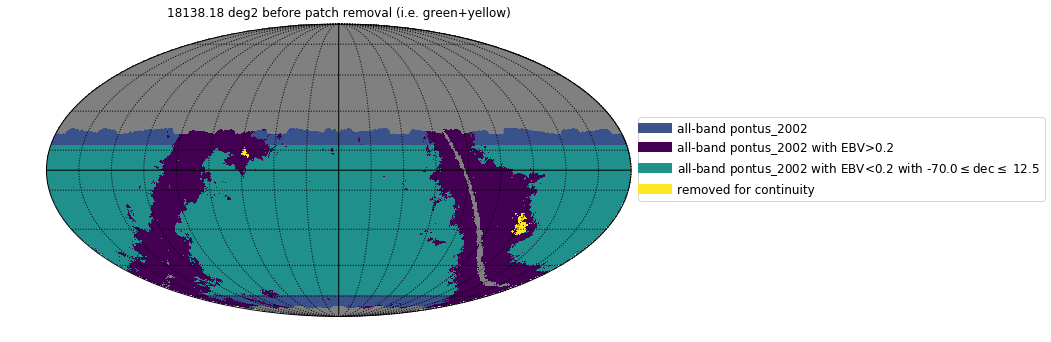

Saved WFDfootprint_nside256.png


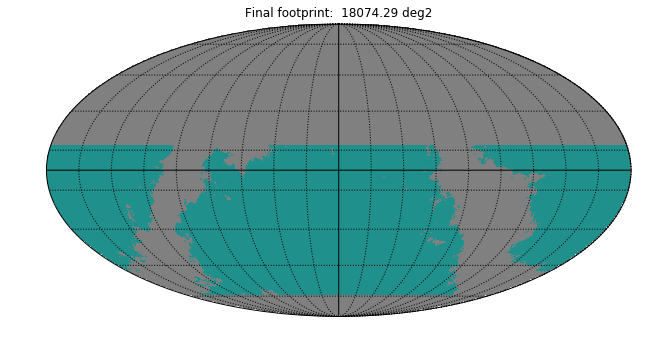

In [6]:
# set up the masked array to plot skymaps
nPix = hp.nside2npix(nside)
val = np.zeros(nPix)+1.
footprint = val.view(np.ma.MaskedArray)
footprint.mask = [True]*nPix
footprint.fill_value = np.nan

########################################################################################################################
# implement a declination cut
pix_ra, pix_dec = slicer._pix2radec(good_ebv_pix)
min_dec, max_dec = -70., 12.5
dec_cut_ind = np.where((np.degrees(pix_dec) >= min_dec) & (np.degrees(pix_dec) <= max_dec))[0]

footprint.mask[allBandPixels]= False
footprint.data[:]= 0
footprint.data[good_ebv_pix]= 50
footprint.data[good_ebv_pix[dec_cut_ind]]= 100

########################################################################################################################
# mask out some islands
ra, dec = -118., -29.5
c = SkyCoord(ra = ra*u.degree, dec = dec*u.degree)
regionPixels_1 = hp.query_disc(nside = nside, vec = c.cartesian.xyz, radius =.14, inclusive = True)

footprint.data[[f for f in regionPixels_1 if f in good_ebv_pix]]= 200

ra, dec = 56., 10.
c = SkyCoord(ra = ra*u.degree, dec = dec*u.degree)
regionPixels_2 = hp.query_disc(nside = nside, vec = c.cartesian.xyz, radius =.09, inclusive = True)
footprint.data[[f for f in regionPixels_2 if f in good_ebv_pix]]= 200

# plot skymaps
plt.clf()
hp.mollview(footprint, flip='astro', rot=(0,0,0), cbar=False,
            title='%.2f deg2 before patch removal (i.e. green+yellow)'%(len(dec_cut_ind)*hp.nside2pixarea(nside=256, degrees=True)))
hp.graticule(dpar=20, dmer=20, verbose=False)
# add legend
ax = plt.gca()
cmap = plt.cm.viridis
custom_lines = [Line2D([0], [0], color=cmap(0.25), lw=10),
                Line2D([0], [0], color=cmap(0), lw=10),
                Line2D([0], [0], color=cmap(0.5), lw=10),
                Line2D([0], [0], color=cmap(1.), lw=10)]
ax.legend(custom_lines,
          ['all-band pontus_2002', 'all-band pontus_2002 with EBV>0.2',
           r'all-band pontus_2002 with EBV<0.2 with %s$\leq$dec$\leq$ %s'%(min_dec, max_dec),
          'removed for continuity'],
         fontsize=12, bbox_to_anchor=(1,.7))
filename = 'WFDfootprint_nside%s_intermediates_RandomDitherPerNight.png'%nside
plt.savefig('%s/%s'%(outDir, filename), format='png', bbox_inches='tight')
print('Saved %s'%filename)
plt.show()

########################################################################################################################
# finalized
good_pixels = good_ebv_pix[dec_cut_ind]
good_pixels = [f for f in good_pixels if f not in regionPixels_1]
good_pixels = [f for f in good_pixels if f not in regionPixels_2]
footprint.mask =  [True]*nPix
footprint.mask[good_pixels]= False
footprint.data[good_pixels]= 100
footprint.fill_value = np.nan

plt.clf()
hp.mollview(footprint, flip='astro', rot=(0,0,0), cbar=False,
            title='Final footprint:  %.2f deg2'%(len(good_pixels)*hp.nside2pixarea(nside=256, degrees=True)))
hp.graticule(dpar=20, dmer=20, verbose=False)
filename = 'WFDfootprint_nside%s.png'%nside
plt.savefig('%s/%s'%(outDir, filename), format='png', bbox_inches='tight')
print('Saved %s'%filename)
plt.show()

**Now lets save the data:**
1. pixel numbers for anyone who wants the mask for the proposed WFD footprint.
2. undithered fieldIDs in the proposed region for the OpSim team.

In [7]:
# save the pixel numbers
print('\n%s pixels here'%len(good_pixels))
filename = 'WFDfootprint_nside%s_HEALPixels.csv'%(nside)
pd.DataFrame({'pixNum': good_pixels}).to_csv('%s/%s'%(outDir, filename), index=False,)
print('Saved %s'%filename)


344562 pixels here
Saved WFDfootprint_nside256_HEALPixels.csv


In [8]:
# find the undithered fields ids. first set up the database and slicer.
opsdb = db.OpsimDatabase(dbpath)
simdata = opsdb.fetchMetricData(['fieldId', 'fieldRA', 'fieldDec'],  # assume v4 outputs: fieldID in v3
                                sqlconstraint=None)
slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                               latLonDeg=opsdb.raDecInDeg, nside=nside)
slicer.setupSlicer(simdata)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


In [9]:
%%time
# now find all the fieldIDs that have observations
fID_list = []
for pixel in good_pixels:
    indObsInPixel = slicer._sliceSimData(pixel)
    fID_list += list(simdata[indObsInPixel['idxs']]['fieldId']) # fieldIDs corresponding to pixel
    
fID_list = np.unique(fID_list)

CPU times: user 3min 51s, sys: 19.1 s, total: 4min 10s
Wall time: 4min 16s


In [10]:
# some checks
# read in the undithered fieldIDs for the entire EBV<0.2 region
files =  [f for f in os.listdir(outDir) if f.endswith('pickle') and not f.__contains__('RandomDither')]
for file in files:
    print('Reading in %s'%file)
    with open('%s/%s'%(outDir, file), "rb") as input_file:
        saved_data = pickle.load(input_file)
    for key in saved_data: print('%s: %s entries'%(key, len(saved_data[key])))
        
good_ebv_pix = saved_data['pixNum']

# now check how many field we have now vs. before
print('\n%s fieldIDs here'%len(fID_list))
print('%s fieldIDs from before'%len(saved_data['fieldIDs']))

Reading in 10yrFootprint_pontus_2002_nside256_NoDither_ebv<0.2.pickle
pixNum: 384774 entries
fieldIDs: 2816 entries

2598 fieldIDs here
2816 fieldIDs from before


Okay good, saved_data had the fieldIDs for the entire EBV<0.2 region so there should be more fieldIDs in the older list.

In [11]:
%%time
# another check
in_old = set(saved_data['fieldIDs']) - set(fID_list)
print('\n%s ids in old list but not in new'%len(in_old))

in_new = set(fID_list)-set(saved_data['fieldIDs'])
print('\n%s ids in new list but not in old\n'%len(in_new))


218 ids in old list but not in new

0 ids in new list but not in old

CPU times: user 1.95 ms, sys: 170 µs, total: 2.12 ms
Wall time: 2.05 ms


In [12]:
# okay now save the fieldIDs
filename = 'WFDfootprint_nside%s_undithered_fieldIDs.csv'%(nside)
pd.DataFrame({'fieldID': fID_list}).to_csv('%s/%s'%(outDir, filename), index=False,)
print('Saved %s'%filename)

Saved WFDfootprint_nside256_undithered_fieldIDs.csv
